In [103]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize,fsolve,root_scalar
from scipy.stats import norm
import matplotlib.pyplot as plt

In [104]:
df = pd.read_excel('spx_quotedata20220308_all.xlsx')
pd.set_option('display.max_columns', 25)
df["Expiration Date"] = pd.to_datetime(df["Expiration Date"])
print(df.head())


  Expiration Date                Calls  Last Sale  Net     Bid     Ask  \
0      2022-03-09  SPXW220309C03000000       0.00  0.0  1151.7  1168.9   
1      2022-03-09  SPXW220309C03200000       0.00  0.0   951.7   969.1   
2      2022-03-09  SPXW220309C03300000       0.00  0.0   851.2   869.3   
3      2022-03-09  SPXW220309C03400000       0.00  0.0   751.7   769.1   
4      2022-03-09  SPXW220309C03500000     735.06  0.0   651.2   669.4   

   Volume      IV   Delta  Gamma  Open Interest  Strike                 Puts  \
0       0  4.3394  1.0000    0.0              0    3000  SPXW220309P03000000   
1       0  3.6439  0.9999    0.0              0    3200  SPXW220309P03200000   
2       0  3.3092  0.9999    0.0              0    3300  SPXW220309P03300000   
3       0  2.9763  0.9998    0.0              0    3400  SPXW220309P03400000   
4       0  2.6471  0.9998    0.0             10    3500  SPXW220309P03500000   

   Last Sale.1  Net.1  Bid.1  Ask.1  Volume.1    IV.1  Delta.1  Gamma.1  \

In [105]:
# Call price as middle of bid and ask
df["Mid"] = (df["Bid"] + df["Ask"]) / 2

# Put price
df["Mid.1"] = (df["Ask.1"] + df["Bid.1"])/2

S0 = 4170.7002

# List of unique maturities
maturities = df["Expiration Date"].unique()

# Define model function as call put indentity
def model(x,*args):
    S0,df_mat = args
    call_put_identity = df_mat["Mid"] - df_mat["Mid.1"] - (x[0] * S0 - x[1] * df_mat["Strike"])
    return call_put_identity.values

# Define squared deviation function
def squared_deviation(x,*args):
    call_put_indentities = model(x,*args)
    return np.sum((call_put_indentities- np.mean(call_put_indentities))**2)

B0 = [0.9]
D0 = [0.9]
for maturity in maturities:
    #Ensure that we have positive zero coupon bond prices and dividend discount factors
    df_mat = df[df["Expiration Date"] == maturity]
    cons = [
    

        # Add constraint to ensure that the sum of the call put identities is close to 0, necessary for the optimization to converge
        {'type': 'eq', 'fun': lambda x:  np.sum(model(x,S0,df_mat)) }
    ]   

    
    # Minimize squared deviation
    m = minimize(squared_deviation,[D0[-1],B0[-1]],args=(S0,df_mat),constraints=cons)

    D0.append(m.x[0])
    B0.append(m.x[1])

term_structure = pd.DataFrame({"Maturity":maturities,"D0":D0[1:],"B0":B0[1:]})

term_structure



,Maturity,D0,B0
0,2022-03-09,0.997496,0.999965
1,2022-03-11,0.997462,1.000079
2,2022-03-14,0.997263,1.000150
3,2022-03-16,0.997030,0.999847
4,2022-03-18,0.996945,0.999927
5,2022-03-21,0.997252,1.000222
6,2022-03-23,0.997327,1.000346
7,2022-03-25,0.996831,0.999867
8,2022-03-28,0.996913,0.999969
9,2022-03-30,0.996952,1.000063


In [106]:
term_structure["Forward Prices"] = S0 * term_structure["D0"] / term_structure["B0"]

$$
S(T) = S_0 \exp\left( \int_0^T \left( r(t) - q(t) - \frac{1}{2} \sigma(t)^2 \right) dt + \int_0^T \sigma(t) dW(t) \right)
$$

However, since \( \sigma(t) \) is a piecewise function, we can express it as:

$$
\int_0^T \sigma(t) dt = \sum_{i=1}^{n} \int_{T_{i-1}}^{T_i} \sigma_i(t) dt
$$

Moreover, \( \sigma_i(t) \) is constant on the intervals \([T_{i-1}, T_{i}]\), so we have:

$$
\sum_{i=1}^{n} \int_{T_{i-1}}^{T_i} \sigma_i(t) dt = \sum_{i=1}^{n} \sigma_i (T_{i}-T_{i-1})
$$

And we can express the discount factors as:

$$
\exp\left(-\int_0^T r(t) dt\right) = B(0,T)
$$

$$
\exp\left(-\int_0^T q(t) dt\right) = D(0,T)
$$

This leads us to:

$$
S(T) = S(0) \frac{D(0,T)}{B(0,T)} \exp\left(-\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i \int_{T_{i-1}}^{T_i} dW(t)\right)
$$

Now, the payoff for a European call option is given by:

$$
C = \mathbb{E}_{\beta} \left[\max(S(T) - K, 0) \exp\left(-\int_0^T r(t) dt \right)\right]
$$

This can be rewritten as:

$$
C = \exp\left(-\int_0^T r(t) dt\right) \mathbb{E}_{\beta} \left[S(T) \mathbb{I}(S(T) > K)\right] - \exp\left(-\int_0^T r(t) dt\right) K \mathbb{E}_{\beta} \left[\mathbb{I}(S(T) > K)\right]
$$

Which simplifies to:

$$
C = \exp\left(-\int_0^T r(t) dt\right) \mathbb{E}_{\beta}\left[S(T) \mathbb{I}(S(T) > K)\right] - \exp\left(-\int_0^T r(t) dt\right) K \mathbb{P}_{\beta}(S(T) > K)
$$

Now, using the properties of the normal distribution, we have:

$$
\mathbb{P}_{\beta}(S(T) > K) = \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) - \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$

Next, we observe that:

$$
\frac{S(T)}{S(0)} \cdot \frac{D(0,T)}{B(0,T)} = \exp\left(-\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i \int_{T_{i-1}}^{T_i} dW(t)\right)
$$

This represents an exponential martingale. By applying Girsanov's theorem, we can change the measure from:

$$
\mathbb{P} \quad \text{to} \quad \mathbb{Q}
$$

We then have:

$$
W_Q(T_{i}) - W_Q(T_{i-1}) = W(T_{i}) - W(T_{i-1}) - \sigma_i (T_{i}-T_{i-1})
$$

Consequently, \( S(T) \) becomes:

$$
S(T) = S(0) \frac{D(0,T)}{B(0,T)} \exp\left(+\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i (W_Q(T_{i}) - W_Q(T_{i-1}))\right)
$$

Thus, we find:

$$
\mathbb{E}_{\beta}\left[S(T) \mathbb{I}(S(T) > K)\right] = \frac{S(0)D(0,T)}{B(0,T)} \mathbb{E}_{Q}\left[\mathbb{I}(S(T) > K)\right] = \frac{S(0)D(0,T)}{B(0,T)} \mathbb{P}_{Q}(S(T) > K)
$$

And we express this as:

$$
= \frac{S(0)D(0,T)}{B(0,T)} \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) + \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$

Finally, we arrive at the expression for the call option price:

$$
C = S(0) D(0,T) N(h_1) - K B(0,T) N(h_2)
$$

Where \( h_{1,2} \) are given by:

$$
h_{1,2} = \frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) \pm \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}
$$


In [107]:

for _, row in term_structure.iterrows():
    df_filtered = df[df['Expiration Date'] == row['Maturity']]
    closest_value = df_filtered.iloc[(df_filtered['Strike'] - row['Forward Prices']).abs().argsort()[:1]]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Closest Strike'] = closest_value['Strike'].values[0]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Call Bid'] = closest_value['Bid'].values[0]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Call Ask'] = closest_value['Ask'].values[0]





def find_sigma_i(x,*args):
    S0,maturity,sigma_i,delta_t,type = args
    sum_sigma_i = sum([sigma_i[i]**2 * delta_t[i] for i in range(len(sigma_i))])+x[0]**2 * delta_t[-1]
    h1 = (np.log(S0 / maturity["Closest Strike"]) + np.log(maturity["D0"]/maturity["B0"]) + 0.5 * sum_sigma_i) / np.sqrt(sum_sigma_i)
    h2 = h1 - np.sqrt(sum_sigma_i)
    return maturity[f"Call {type}"] - (S0 * maturity["D0"] * norm.cdf(h1) - maturity["Closest Strike"] * maturity["B0"] * norm.cdf(h2))

sigma_i_bid = []
sigma_i_ask = []
Ti = [pd.Timestamp('2022-03-08')] + maturities.tolist()
delta_t = [(Ti[1]-Ti[0]).days/365]


for i in range(len(term_structure)):
    maturity = term_structure.iloc[i]
    sigma_i_bid.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_bid,delta_t,"Bid"))[0])
    sigma_i_ask.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_ask,delta_t,"Ask"))[0])
   
    if i < len(term_structure)-1:
        delta_t.append(int((term_structure.iloc[i+1]["Maturity"]- term_structure.iloc[i]["Maturity"]).days)/365)


print(sigma_i_bid)
print(sigma_i_ask)



[0.34189841918343594, 0.3593458074130287, 0.2535939970892459, 0.39991057756620674, 0.35425416242479624, 0.21229545651448545, 0.3330237436453545, 0.3189577914542254, 0.20778873112983023, 0.31500745361422555, 0.30628406375292816, 0.3677964382384014, 0.18908443320046503, 0.3168579876196398, 0.31366724294640363, 0.27627507938494217, 0.2516848197822497, 0.27954680015342587, 0.2723543943293364, 0.23437853595641275, 0.2662853953018736, 0.23432750463507812, 0.2656478155825405, 0.22617397532343347, 0.2603902931647231, 8.67156420136549e-06, 0.3195939042699774, -0.00016916521929495729, 0.3161589756034889, 0.23828761850318425, 0.23361000866175413, 7.001848262434569e-05, 0.2700148168494913, -0.00022434623658889848, 2.25431841134829e-05, 0.180343860622603, 0.18107864263389853, 0.10153150929114016, 0.21490879995043718, 0.20487689232816503]
[0.41327494889878663, 0.34885648268324676, 0.23777736992342138, 0.40235111380786204, 0.35607865949551154, 0.2153322198548733, 0.33251991212214316, 0.32263154284266

C:\Users\maxim\AppData\Local\Temp\ipykernel_1720\1405859326.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sigma_i_bid.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_bid,delta_t,"Bid"))[0])
C:\Users\maxim\AppData\Local\Temp\ipykernel_1720\1405859326.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sigma_i_bid.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_bid,delta_t,"Bid"))[0])
C:\Users\maxim\AppData\Local\Temp\ipykernel_1720\1405859326.py:28: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sigma_i_ask.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_ask,delta_t,"Ask"))[0])


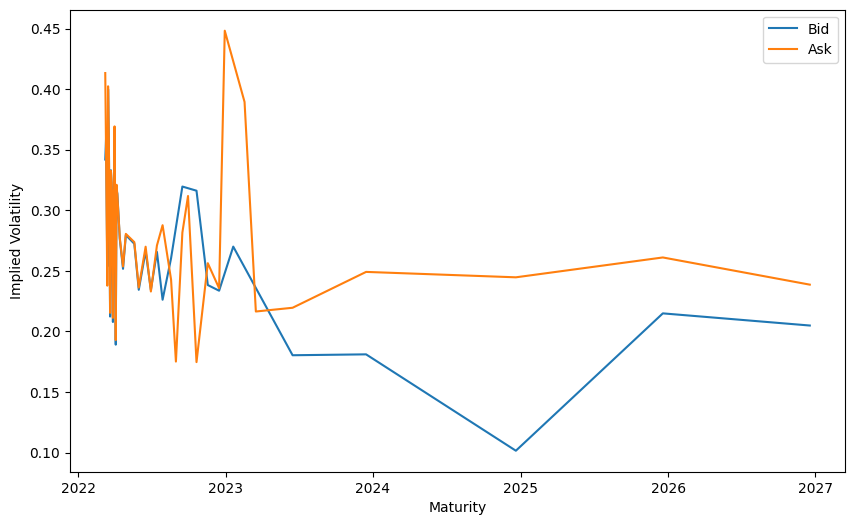

In [108]:
new_maturities_bid = []
new_maturities_ask = []
new_sigma_i_bid = []
new_sigma_i_ask = []



for i in range(len(maturities)):
    if sigma_i_bid[i] > 0.001:
        new_maturities_bid.append(maturities[i])
        new_sigma_i_bid.append(sigma_i_bid[i])
    if sigma_i_ask[i] > 0.001:
        new_sigma_i_ask.append(sigma_i_ask[i])    
        new_maturities_ask.append(maturities[i])




fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(new_maturities_bid, new_sigma_i_bid, label='Bid')
ax.plot(new_maturities_ask, new_sigma_i_ask, label='Ask')
ax.set_xlabel('Maturity')
ax.set_ylabel('Implied Volatility')
ax.legend()
plt.show()




$$
C = S(0) B(0,T) \exp(gT) N(h_1) + S(0) D(0,T)^{1-\alpha} B(0,T)^\alpha N(h_2) \exp(\frac{\alpha^2-\alpha}{2}\int_0^T\sigma(t)^2 dt)
$$

Where \( h_{1,2} \) are given by:

$$
h_1 = \frac{\left(\frac{gT}{1-\alpha}\right) - \ln\left(\frac{D(0,T)}{B(0,T)}\right) + \frac{1}{2} \int_0^T \sigma(t)^2 dt}{\sqrt{\int_0^T \sigma(t)^2 dt}}
$$

$$
h_2 = \frac{\left(-\frac{gT}{1-\alpha}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) + (\frac{1}{2}-\alpha) \int_0^T \sigma(t)^2 dt}{\sqrt{\int_0^T \sigma(t)^2 dt}}
$$

In [109]:
import numpy as np
from scipy.stats import norm



def payoff(g,*args):
     S0, D, B, T, alpha, sigma_square = args
     numerator = (g * T) / (1-alpha) - np.log(D / B)
     denominator = np.sqrt(sigma_square)

     h1 = norm.cdf((numerator + 0.5 * sigma_square) / denominator)
     h2 = norm.cdf((-numerator +(0.5-alpha) * sigma_square) / denominator)

     C = (S0 * (D**(1 - alpha)) * (B**alpha) * h2 *np.exp(alpha*(alpha-1)/2 * sigma_square) +
          S0 * B * np.exp(g * T) * h1 )
     return C-S0




sigma_square = 0
maturities_bid = [pd.Timestamp('2022-03-08')] + new_maturities_bid
for i in range(len(new_sigma_i_bid)):
     sigma_square += new_sigma_i_bid[i]**2 * (maturities_bid[i+1] -  maturities_bid[i]).days/365

sigma_square2 = 0   
maturities_ask = [pd.Timestamp('2022-03-08')] + new_maturities_ask
for i in range(len(new_sigma_i_ask)):
     sigma_square2 += new_sigma_i_ask[i]**2 * (maturities_ask[i+1] -  maturities_ask[i]).days/365


#sigma_square = (sigma_square + sigma_square2) / 2

sigma_square = sigma_square2


g025 = fsolve(payoff, [0], args=(S0, D0[-1], B0[-1], (Ti[-1] - Ti[0]).days/365, 0.25, sigma_square))[0]
g05 = fsolve(payoff, [0], args=(S0, D0[-1], B0[-1], (Ti[-1] - Ti[0]).days/365, 0.5, sigma_square))[0]

g075 = fsolve(payoff, [0], args=(S0, D0[-1], B0[-1], (Ti[-1] - Ti[0]).days/365, 0.75, sigma_square))[0]
print(g025,g05,g075)



-0.02175960047881828 0.004730163397526423 0.01956000132233885


In [110]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def portfolio(l):

    T = (Ti[-1] - Ti[0]).days/365
    alpha = l[0]
    g = l[1]
    size = l[2]
    S = np.linspace(0, 5*S0, size)
    payoffs = np.maximum(S0*np.exp(g*T), S0**alpha * S**(1-alpha))

    strikes = df_mat["Strike"].values
    # Calculate option values
    calls = []
    puts = []
    options = []

    for s in S:
        option = np.maximum(S0 * np.exp(g * T), S0 ** alpha * s ** (1 - alpha))
        options.append(option)
        calls.append([max(s - strike, 0) for strike in strikes])
        puts.append([max(strike - s, 0) for strike in strikes])

    calls = np.array(calls)
    puts = np.array(puts)
    options = np.array(options)
    num_calls = calls.shape[1]
    num_puts = puts.shape[1]

    # Define the objective function to minimize
    def objective(weights):
        call_weights = weights[:num_calls]
        put_weights = weights[num_calls:]
        replicated_payoff = calls @ call_weights + puts @ put_weights
        # Calculate sum of squared errors
        sse = list(replicated_payoff - options)
        for i in range(len(sse)):
            sse[i] = sse[i] if sse[i] > 0 else sse[i]**2
        sse = sum(sse)
        return sse

    # Initial guess for weights (can be zeros or any other reasonable guess)
    initial_weights = np.zeros(num_calls + num_puts)

    # Bounds: allow negative weights
    bounds = [(-np.inf, None) for _ in range(num_calls + num_puts)]

    # Solve the optimization problem
    result = minimize(objective, initial_weights, bounds=bounds, method='L-BFGS-B')

    # Check the result
    if result.success:
        weights = result.x
        call_weights = weights[:num_calls]
        put_weights = weights[num_calls:]
        
    else:
        print("Optimization failed:", result.message)




    price = 0
    for i in range(len(call_weights)):
        if call_weights[i] > 0:
            price += call_weights[i] * df_mat["Ask"].values[i]
        else:
            price += call_weights[i] * df_mat["Bid"].values[i]
    for i in range(len(put_weights)):
        if put_weights[i] > 0:
            price += put_weights[i] * df_mat["Ask.1"].values[i]
        else:
            price += put_weights[i] * df_mat["Bid.1"].values[i]



    replicated_payoff = calls @ call_weights + puts @ put_weights
    diff = replicated_payoff - options
    min_diff = np.min(diff)
    price += term_structure["B0"].values[-1] * -min_diff
    print("Replicating portfolio price:", price)
    print("Call weights:", call_weights)
    print("Put weights:", put_weights)
    print("Number of ZCBs:", -min_diff)
    print("Difference:", diff-min_diff)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(S, options, label='Option Payoff', color='blue')
    replicated_payoff = calls @ call_weights + puts @ put_weights - min_diff
    ax.plot(S, replicated_payoff, label='Replicated Payoff', color='orange')
    ax.legend()
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Payoff')
    plt.title('Option Payoff vs. Replication Strategy (SSE Minimization)')
    plt.grid()
    plt.show()



Replicating portfolio price: 4555.532930732025
Call weights: [ 0.28086879  0.35992802  0.31913713  0.23504574  0.17898365  0.06545076
 -0.04753301 -0.07309521 -0.08179809 -0.12802403 -0.25082201 -0.31222187]
Put weights: [-0.28179417 -0.08537668 -0.05281497 -0.09289356 -0.11961316 -0.11577259
  0.00600204  0.06847414  0.1771491   0.21895439  0.15484278  0.12278589]
Number of ZCBs: 4.132106279661457
Difference: [  4.02761694   4.06244672   4.0972765    4.13210628   4.11756443
   3.58482596  96.25203402   4.0196661    9.85008278   3.36459094
   4.13216546   9.27394691   3.58520934   4.13021924  68.15467738
 176.92946066 137.36875121 103.61671203  75.2488586   51.89348252
  33.22266624  18.94519946   8.80092329   2.55616273   0.
   0.94120524   5.20568715  12.63435886  23.08133852  36.41242213
  52.50377942  71.24083388  92.51729584 116.23432362 142.29979229]


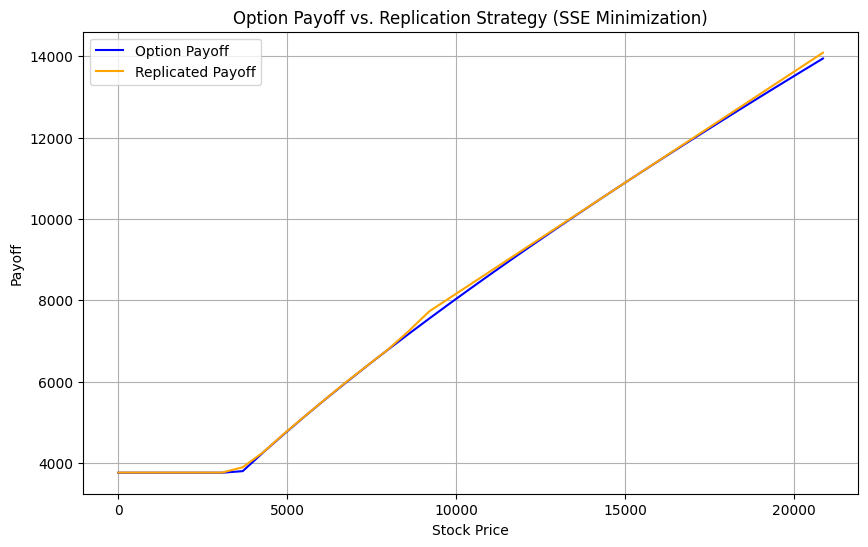

In [111]:
portfolio([0.25, g025, 35])

Replicating portfolio price: 4535.525810458627
Call weights: [ 0.27780049  0.19169481  0.20652997  0.22206196  0.22208435  0.12262658
 -0.06275785 -0.08789971 -0.06729062 -0.1935498  -0.27551153 -0.29004703]
Put weights: [-0.26507496 -0.23300663 -0.14431021 -0.08446085 -0.05489325 -0.03616809
  0.01482162  0.07832089  0.21711807  0.17949907  0.15663     0.17164047]
Number of ZCBs: 4.113348279157435
Difference: [  4.11439458   4.08718507   4.05997556   4.03276606   4.00555655
   3.97834704   3.95113754   3.92392803   3.89671852   3.86950901
   3.84229951   6.07258732   9.02708537  11.98158342  11.61766787
   4.89243367   1.21248363   9.06590029  49.7922983   86.21494627
  53.54338625  23.63707108   9.68426713   5.00240867   2.56238684
   2.22545515   3.86661435   7.37277783  12.64124032  10.23269544
   7.52103787   5.70492306   3.68572849   3.03220652   3.68273003
  35.6677713   73.86497759 112.23103145 149.37879388 171.17009742
 162.12446576 146.72075413 132.25859371 118.7045507  106.0

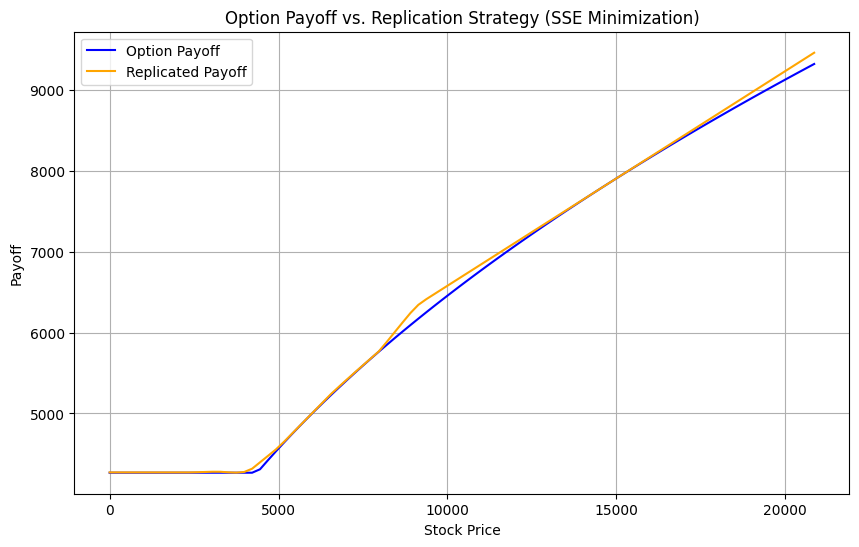

In [112]:
portfolio([0.5, g05, 90])

Replicating portfolio price: 4522.838306939875
Call weights: [ 0.25077034  0.25084039  0.11786293  0.11505401  0.13426009  0.0927277
  0.00489504 -0.02523418 -0.10928767 -0.20374272 -0.23779219 -0.29353429]
Put weights: [-0.25061694 -0.2245006  -0.17782156 -0.10508617 -0.10907095 -0.03133776
  0.09809814  0.02013119  0.18281151  0.19702553  0.20147471  0.19893006]
Number of ZCBs: 3.228404430916271
Difference: [3.22983096e+00 3.22332328e+00 3.21681560e+00 3.21030792e+00
 3.20380024e+00 3.19729256e+00 3.19078488e+00 3.18427720e+00
 3.17776952e+00 3.17126184e+00 3.16475415e+00 3.15824647e+00
 3.15173879e+00 3.14523111e+00 3.14690780e+00 3.16728189e+00
 3.18765598e+00 3.20803007e+00 3.22840417e+00 6.66111386e+00
 1.12972604e+01 1.59334070e+01 1.12598320e+01 5.69296320e+00
 1.71353834e+00 2.00345735e+00 2.29337635e+00 2.58329536e+00
 2.87321436e+00 8.19376959e+00 1.92416300e+01 3.02894904e+01
 4.13373508e+01 5.23852112e+01 6.34330716e+01 6.14138614e+01
 4.00014371e+01 1.92583902e+01 5.24038

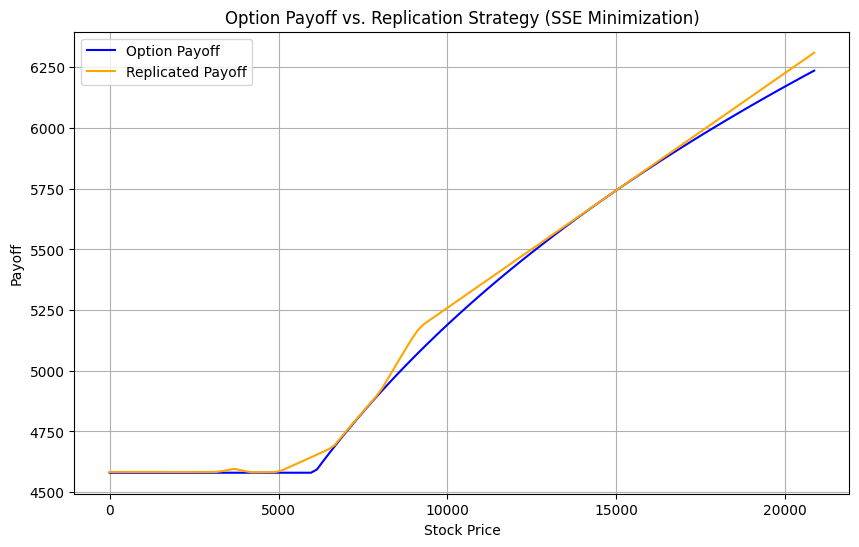

In [113]:
portfolio([0.75, g075, 120])